In [9]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request, json
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

plt.rcParams['figure.figsize'] = (5, 5)
plt.rc('font', size=5)

In [11]:
res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas?treinamento=true")
data = json.loads(res.read())
exemplos_treinamento = data['data']

In [12]:
sentences = []
pos = []
maxlen = 40

for exemplo in exemplos_treinamento:
    tokens = text_to_word_sequence(exemplo['txtVaga'])
    
    aplicacao = exemplo['isApplied']
    sentences.append(tokens)
    pos.append([str(aplicacao)])
    
    if len(tokens) > maxlen:
        maxlen = len(tokens)
        print("Maxlen atualizado: ",  maxlen)

In [13]:
word_list = ['<pad>'] + sorted(set(sum(sentences, []))) + ['_UNKNOWN']
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}
pos_list = sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))
X = pad_sequences(X, maxlen=maxlen, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)
y = pad_sequences(y, maxlen=1, padding='post')

json_str = json.dumps(word2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

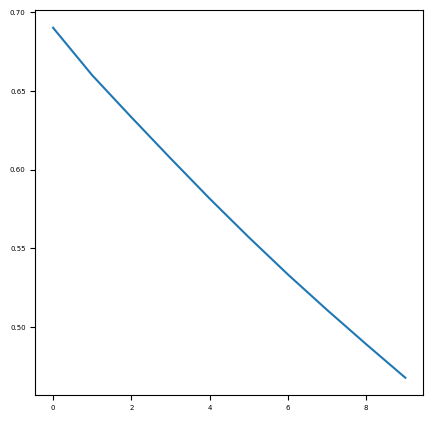

In [14]:
num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)
exemples_dim = len(sentences)
batch_size = 256
epochs = 10

optimizer = Adam()
loss_function = BinaryCrossentropy()
additional_metrics = ['accuracy']

model = Sequential()
model.add(Embedding(input_dim, num_classes, input_length=maxlen))
model.add(Bidirectional(LSTM(2), merge_mode='sum'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
#model.summary()

history = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False, validation_split=0.20)

plt.figure()
plt.plot(history.history['loss'])
plt.show()

In [24]:
novo_X = [['desenvolvedor', 'web', 'java', 'júnior', "remoto",]]
novo_X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], novo_X))
novo_X = pad_sequences(novo_X, maxlen=maxlen, padding='post')
y_pred = model.predict(novo_X, batch_size=1)[0]
y_pred

1/1 [==============================] - 0s 13ms/step


array([0.3611197], dtype=float32)

In [16]:
model.save("model.keras")